# CS 466 Final Project
## Prokaryotic Promoter Finding with HMM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
maindir = "/content/drive/My Drive/cs466_final_project/"
datadir = maindir + "data/"
!cp -r "$datadir" .

In [3]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install prettytable
!pip install biopython

In [4]:
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from scipy.stats import norm
from prettytable import PrettyTable

from Bio import SeqIO
from Bio.Seq import Seq

# Promoter Finder implementation


In [5]:
# Read in csv files for transition/emission matrices
transition_probs = pd.read_csv('data/transition.csv', index_col=[0])
emission_probs = pd.read_csv('data/emission.csv', index_col=[0])
init_probs = pd.read_csv('data/initial.csv')

transition_probs.columns = transition_probs.columns.astype(int)
init_probs.columns = init_probs.columns.astype(int)

transition_probs = transition_probs.to_numpy()
emission_probs = emission_probs.to_numpy()
init_probs = init_probs.to_numpy()[0]

In [6]:
np.set_printoptions(threshold=np.inf)

In [7]:
emission_probs

array([[0.24119   , 0.27243   , 0.25342   , 0.23296   ],
       [0.38166667, 0.195     , 0.16      , 0.26666667],
       [0.43833333, 0.08      , 0.09833333, 0.38166667]])

In [8]:
transition_probs

array([[6.0e-01, 2.2e-01, 1.8e-01],
       [6.0e-01, 4.0e-01, 1.0e-11],
       [6.0e-01, 1.0e-11, 4.0e-01]])

In [9]:
init_probs

array([0.98, 0.01, 0.01])

In [10]:
# Map nucleotide to array indices
nuc2idx = {"T": 0, "G": 1, "C": 2, "A": 3}

# Set of states (0: out, 1: in -35 seq, 2: in -10 seq)
Q = [0, 1, 2]
num_states = 3

def log_transition_prob(s, t):
  if transition_probs[s][t] == 0:
    return -np.inf
  return np.log(transition_probs[s][t])

def log_emission_prob(nuc, s):
  x = nuc2idx[nuc]
  if emission_probs[s][x] == 0:
    return -np.inf
  return np.log(emission_probs[s][x])

def log_init_prob(s):
  if init_probs[s] == 0:
    return -np.inf
  return np.log(init_probs[s])

# E.Coli sequence augmented with -10 and -35 promoters to test

In [11]:
# Read promoters dataset for training HMM
promoters = pd.read_csv('data/promoters.txt', header=None)[0]

# Read sequence input from fasta file
for seq_record in SeqIO.parse("data/ecoli_genome.fasta", "fasta"):
  sequence = seq_record.seq

test = sequence[:50] + Seq("TTGACA") + sequence[50:67] + Seq("TATAAT") + sequence[67:100]
expected = Seq('-' * 50 + '+' * 6 + '-' * 17 + '+' * 6 + '-' * 33)

In [12]:
print(test)

AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAATTGACAAAAGAGTGTCTGATAGCTATAATAGCTTCTGAACTGGTTACCTGCCGTGAGTAAAT


# Use Viterbi to find -10 and -35 promoters

In [13]:
# HMM implementation of promoter finder

def promo_finder(sequence):
  # Length of sequence
  seq_len = len(sequence)

  # Viterbi matrix (num_states, seq_len)
  v = np.zeros((num_states, seq_len))
  # Backtrace matrix (num_states, seq_len)
  bt = np.zeros((num_states, seq_len))

  # Runs Viterbi algorithm while saving backpointers
  for idx, nuc in enumerate(sequence):
    if idx == 0:
      for s in Q:
        v[s][idx] = log_init_prob(s) + log_emission_prob(nuc, s)
    else:
      for s in Q:
        temp_v, temp_t = -np.inf, -1
        for t in Q:
          curr_v = v[t][idx-1] + log_transition_prob(t, s) + log_emission_prob(nuc, s)
          if curr_v > temp_v:
            temp_v = curr_v
            temp_t = t
          
        v[s][idx] = temp_v
        bt[s][idx] = temp_t
        
  s = np.argmax(v[:, -1])
  idx = seq_len - 1
  bt_out = []
  while idx >= 0:
    bt_out.append('-' if s == 0 else '+')
    s = int(bt[s][idx])
    idx -= 1
  bt_out = bt_out[::-1]
  
  return bt_out
    

In [14]:
actual = promo_finder(test)

# Most likely states:

In [15]:
tabl = PrettyTable(header=False, border=False)
tabl.add_row(['Sequence', *test])
tabl.add_row(['Actual', *actual])
tabl.add_row(['Expected', *expected])
print(tabl)

 Sequence  A  G  C  T  T  T  T  C  A  T  T  C  T  G  A  C  T  G  C  A  A  C  G  G  G  C  A  A  T  A  T  G  T  C  T  C  T  G  T  G  T  G  G  A  T  T  A  A  A  A  T  T  G  A  C  A  A  A  A  G  A  G  T  G  T  C  T  G  A  T  A  G  C  T  A  T  A  A  T  A  G  C  T  T  C  T  G  A  A  C  T  G  G  T  T  A  C  C  T  G  C  C  G  T  G  A  G  T  A  A  A  T 
  Actual   -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  +  +  +  +  +  +  +  +  +  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  +  +  +  +  +  +  +  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  - 
 Expected  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  +  +  +  +  +  +  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  +  +  +  +  +  +  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -  -

In [16]:
print(test[35:90])
print(str().join(actual[35:90]))
print(expected[35:90])

CTGTGTGGATTAAAATTGACAAAAGAGTGTCTGATAGCTATAATAGCTTCTGAAC
--------+++++++++---------------------+++++++----------
---------------++++++-----------------++++++-----------


# Try to use Baum-Welch algorithm to train HMM parameters

In [17]:
def forward(sequence, init, a, e):
  seq_len = len(sequence)
  f = np.zeros((num_states, seq_len))
  
  for s in Q:
    f[s][0] = init[s] * e[s][nuc2idx[sequence[0]]]

  for i in range(1, seq_len):
    for s in Q:
      for r in Q[1:]:
        f[s][i] += f[r][i-1] * a[r][s]
      f[s][i] = f[s][i] * e[s][nuc2idx[sequence[i]]]

  return f

In [18]:
def backward(sequence, init, a, e):
  seq_len = len(sequence)
  b = np.zeros((num_states, seq_len))

  for s in Q:
    b[s][-1] = 1

  # -1 for index shift, -1 for second last column
  for i in range(seq_len-2, -1, -1):
    for s in Q:
      for t in Q:
        b[s][i] += b[t][i+1] * a[s][t] * e[t][nuc2idx[sequence[i+1]]]

  return b

In [19]:
def baum_welch(sequences, init, a, e, eps):
  converged = 1

  while converged > eps:
    delta = 0
    current = 0
    A = np.zeros((num_states, num_states))
    E = np.zeros((num_states, len(nuc2idx)))

    for idx, seq in enumerate(sequences):
      f = forward(seq, init, a, e)
      b = backward(seq, init, a, e)
      V = np.sum(f, axis=0)[-1]
      current += np.log(V)

      for i in range(len(seq)-1):
        for s in Q:
          E[s][nuc2idx[seq[i]]] += f[s][i] * b[s][i] / V
          for t in Q:
            A[s, t] += f[s][i] * a[s][t] * e[t][nuc2idx[seq[i+1]]] * b[t][i+1] / V
    
    for i in range(3):
      a[i] = np.divide(A[i], np.sum(A[i]))
      e[i] = np.divide(E[i], np.sum(E[i]))

    for i in range(len(sequences)):
      f = forward(sequences[i], init, a, e)
      V = np.sum(f, axis=0)[-1]
      delta += np.log(V)

    converged = abs(current-delta)

  return a, e

# Results are not as expected
## Probabilities too low - Needs more work!

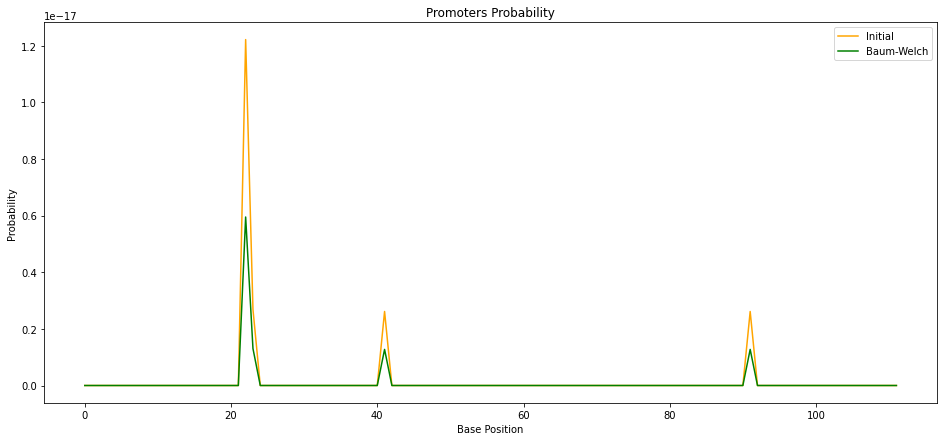

In [21]:
f = forward(test, init_probs, transition_probs, emission_probs)
b = backward(test, init_probs, transition_probs, emission_probs)
probs = np.multiply(f, b) / np.sum(f, axis=0)[-1]

a_estimate, e_estimate = baum_welch(promoters[:10], init_probs, transition_probs, emission_probs, 0.001)
f_bw = forward(test, init_probs, a_estimate, e_estimate)
b_bw = backward(test, init_probs, a_estimate, e_estimate)
probs_bw = np.multiply(f_bw, b_bw) / np.sum(f_bw, axis=0)[-1]

plt.figure(figsize=(16, 7))
plt.title("Promoters Probability")
plt.plot(probs[2], label="Initial", color='orange')
plt.plot(probs_bw[2], label="Baum-Welch", color='green')
plt.xlabel('Base Position')
plt.ylabel('Probability')
plt.legend(loc='best')
plt.show()